In [1]:
from IPython.display import display, HTML, clear_output
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 95%; }    div#maintoolbar-container { width: 99%; }
</style>
"""))
import sys
if (__name__ == '__main__') and (sys.platform == 'darwin'): # check if mac or pc for multiprocessing
    import multiprocessing as mp; mp.set_start_method('forkserver') 
import pandas as pd
import numpy as np
import scipy, itertools, datetime, calendar, workdays, glob, os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, neural_network, tree, linear_model, kernel_ridge, neighbors, svm, tree
from sklearn import preprocessing, metrics, decomposition, preprocessing, model_selection, feature_selection
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from dateutil.parser import parse
from datetime import timedelta
from collections import Counter
from tqdm import tnrange, tqdm_notebook
from clf_fitter import iter_fit, iter_test, iter_predict
from MyClf import MyClf
from helper_functions import *
%matplotlib inline
try:
    import pdblp
except:
    pass

## Feature Build

In [28]:
##########################################################################################################################################################
## Transform and build the feature set from raw bloomberg data contained in pickle file 'historical_data1.pickle'
##########################################################################################################################################################

EQUITY_TICKERS   = ['spy', 'iwm', 'mdy', 'hyg'] #'xiv', 'vxx', 'tvix', 
INDUSTRY_TICKERS = ['xle', 'xlb', 'xlf', 'iyz', 'xlv', 'xlk', 'xlp', 'xlu', 'xly', 'xli'] #'xiv', 'vxx', 'tvix', 
INDEX_TICKERS    = ['spvixstr', 'sx5e', 'vix', 'pcrteqty', 'vvix', 'vxv', 'vxth', 'rxm', 'rvx', 'vxn',
                    'tyvix', 'jpmvxyg7', 'jpmvxyem', 'tradhigh', 'tradlows', 'cvxftncn', 'vxxiv', 'cesiusd', 'cesig10']
                    # 'vcac', 'v2x', 'vhsi', 'vaex', 'vimex', 'tradcads', 'vnky', 'vftse', 'vkospi'
MACRO_TICKERS    = ['nfp tch', 'injcjc', 'usmmmnch', 'injcsp', 'ip chng', 'consexp', 'dgnoxtch', 'pitlchng', 'lei chng', 'napmpmi', 'napmnmi', 'conssent', 'concconf']
VIX_FUTURES      = ['ux1', 'ux2', 'ux3', 'ux4', 'ux5', 'ux6', 'ux7']
VOL_FIELDS       = ['30DAY_IMPVOL_97.5%MNY_DF', '30DAY_IMPVOL_102.5%MNY_DF', '30DAY_IMPVOL_95.0%MNY_DF', '30DAY_IMPVOL_105.0%MNY_DF','3MTH_IMPVOL_95.0%MNY_DF', '3MTH_IMPVOL_105.0%MNY_DF']
OTHER            = ['weight', 'contract_days_length', 'contract_days_left']
equity_tks       = [tk + ' equity' for tk in EQUITY_TICKERS]
industry_tks     = [tk + ' equity' for tk in INDUSTRY_TICKERS]
index_tks        = [tk + ' index' for tk in INDEX_TICKERS]
macro_tks        = [tk + ' index' for tk in MACRO_TICKERS]
spy_vol_tks      = ['SPY_' + tk for tk in VOL_FIELDS]
ux_weighted_tks  = ['ux_weighted', 'ux_weighted_2', 'ux_weighted_3', 'ux_weighted_4', 'ux_weighted_5', 'ux_weighted_6']
other_tks        = ['ctg_curvature', 'ux_weighted', 'ux_weighted_2', 'ux_weighted_3', 'ux_weighted_4', 'ux_weighted_5', 'ux_weighted_6', 'ctg_weighted', 'ctg_weighted_1v2', 'ctg_weighted_1d_lag', 'ux_weighted_1d_lag', 'vix_1d_lag', 'ux_wgt_prem', 'contract_days_times_premium', 'contract_days_remaining_ux2ux1_premium', 'contract_days_remaining_ux1vix_premium', 'spy_MACD', 'spy_5d_ema', 'spy_5d_rv', 'spy_10d_rv', 'spy_20d_rv', 'spy_30d_rv', 'spy_6m_rv', 'vix_spy_10rv_prem', 'vix_spy_20rv_prem', 'vix_spy_6mrv_prem', 'spy_rv_momentum', 'ctg_momentum', 'ctg_momentum_chg', 'spvixstr_1dl', 'spvixstr_2dl', 'spvixstr_3dl', 'spvixstr_4dl', 'spvixstr_5dl', 'spy_iwm_10d_corr', 'spy_mdy_10d_corr', 'spy_hyg_10d_corr', 'xle equity_pct_corr', 'xlb equity_pct_corr', 'xlf equity_pct_corr', 'iyz equity_pct_corr', 'xlv equity_pct_corr', 'xlk equity_pct_corr', 'xlp equity_pct_corr', 'xlu equity_pct_corr', 'xly equity_pct_corr', 'xli equity_pct_corr', 'spvixstr_2d_perf', 'spvixstr_3d_perf', 'spvixstr_5d_perf', 'spy_30d_skew_95_105', 'spy_30d_skew_97.5_102.5', 'spy_3m_skew_95_105']
mytks = equity_tks.copy()
mytks.extend(industry_tks)
mytks.extend(index_tks)
mytks.extend(macro_tks)
mytks.extend(spy_vol_tks)
mytks.extend(VIX_FUTURES)
mytks.extend(OTHER)

# select raw feature transformations (pct/net change, exponential moving average, etc.
# based on on the excel mapping table feature_mapping.xlsx
mapping_table = pd.read_excel('feature_mapping.xlsx', index_col=0)
feature_list = list(mapping_table[mapping_table.price == 1].index)
feature_list.extend([feature + '_chg' for feature in mapping_table[mapping_table.net_chg == 1].index])
feature_list.extend([feature + '_pct' for feature in mapping_table[mapping_table.pct == 1].index])
feature_list.extend([feature + '_ema3d' for feature in mapping_table[mapping_table.ema3d == 1].index])
feature_list.extend([feature + '_macd' for feature in mapping_table[mapping_table.macd == 1].index])
feature_list.extend([feature + '_pct_ema3d' for feature in mapping_table[mapping_table.pct_ema3d == 1].index])

# adjust for indicators with a 1 day lag
INDICATORS_WITH_LAG = ['tradhigh index', 'tradlows index'] + spy_vol_tks
features_to_pct = equity_tks + industry_tks + index_tks + macro_tks + ux_weighted_tks
features_to_chg = index_tks + macro_tks + ux_weighted_tks + spy_vol_tks + ux_weighted_tks
features_to_macd = equity_tks + index_tks + ux_weighted_tks + macro_tks
features_to_ema = equity_tks + index_tks + macro_tks + spy_vol_tks + ux_weighted_tks + other_tks + [tk + '_pct' for tk in equity_tks + industry_tks + index_tks + ux_weighted_tks]

pipeline_feature_build = Pipeline([
    ('shift_data', ShiftColumns(INDICATORS_WITH_LAG, 1)),
    ('add_vix_features', AddVIXFeatures()),
    ('add_percent_change', PercentageChange(features=features_to_pct)),
    ('fill_na', FillNA(method='ffill')),
    ('add_other_features', AddOtherFeatures()),
    ('add_net_change', NetChange()),
    ('fill_nas', FillNA(value=0)),
    ('fill_inf', FillInf(value=0)),
    ('add_macd', MACD(p1=10, p2=2, signal=2, features=features_to_macd)),
    ('add_ema', EMA(ewm=3, features=features_to_ema)),
    ('select_features', FeatureExtractor(features=feature_list)),
])

# load custom pipeline with pre-selected features for testing
my_pipeline_fs3 = joblib.load('my_pipeline_fs3.pkl')
# load a pickled grid search
gscv3 = joblib.load('gscv3.pkl')

def get_dataset(how='regression', from_date='2006-12-15', to_date=(datetime.datetime.today()-datetime.timedelta(1)).strftime('%Y%m%d'),
                y_lag=-1, y_var='spvixstr index_pct', threshold=0.00, classification_categories=[-1,1], prediction_days=1, time_step_adjustment=False):
    '''Helper function to transform the dataset for ML algo.
    
    Parameters
    ----------
    how : classification, regression, prediction
         'classification': return X and y, and forward return, where y the binary classification based on specified thresholds 
         'regression'    : return X and y, where y is the return
         'prediction'    : return dataset with only last row for prediction

    y_lag: integer, --DEPRECATED

    y_var: string, default: 'spvixstr index_pct'
        select the dependent variable
    
    threshold: float, default: 0.00
        threshold to use for classifier categorization
    
    classification_categories: list, default[-1,1]
        2 elements for binary classification
    
    prediction_days: int, default: 1
        cumulative return of y dependent variable over x number of days
    
    time_step_adjustment: bool: default: false
        adjust the time step for X so as to avoid the look-ahead bias

    Returns
    ----------
    Data frame for training/prediction.
    '''

    threshold = 0.00
    data = pd.read_pickle('historical_data1.pickle')
    data = data[mytks]
    X = pipeline_feature_build.fit_transform(data)
    y = X[y_var]
    y = y.rolling(prediction_days).apply(lambda x: np.prod(np.nan_to_num(x)+1)-1).shift(-prediction_days)
    date_mask = (data.index > from_date) & (data.index <= to_date)
    X_mask, y_mask, dates_mask = X[date_mask], y[date_mask], X.index[date_mask]
    if time_step_adjustment:
        X_mask, y_mask, dates_mask = X_mask[::prediction_days], y_mask[::prediction_days], dates_mask[::prediction_days]
    if how == 'regression':
        return X_mask, y_mask
    elif how == 'classification':
        y_clf = np.array([classification_categories[0] if y_ <= threshold else classification_categories[1] for y_ in y_mask])
        return X_mask, y_clf, y_mask
    elif how == 'prediction':
        return X.tail(1)
    else:
        raise ValueError('{} is not a valid option.'.format(how))

rand_state = 1
class_weights1 = {1: 1.05, -1: 1}
class_weights2 = {1: 1.08, -1: 1}
class_weights3 = {1: 1.15, -1: 1}

In [5]:
# Scikit-learn classifier dictionary
sk_classifiers = {    
    'Ridge1':      linear_model.RidgeClassifier(alpha=1.0, max_iter=100000, tol=1e-5, solver='lsqr', class_weight=None, fit_intercept=True, random_state=rand_state),
    'RidgeGS1':    linear_model.RidgeClassifier(alpha=25.118864315095795, max_iter=None, solver='sparse_cg', class_weight=class_weights1, random_state=rand_state, tol=0.1),
    'RidgeGS2':    linear_model.RidgeClassifier(alpha=1, max_iter=None, solver='sparse_cg', class_weight=class_weights1, random_state=rand_state, tol=0.05),
    'Logistic1':   linear_model.LogisticRegression(C=1, penalty='l1', n_jobs=-1, max_iter=100000, solver='liblinear', random_state=rand_state),
    'LogisticGS':  linear_model.LogisticRegression(C=1, penalty='l2', n_jobs=-1, class_weight=class_weights2, max_iter=100000, solver='liblinear', random_state=rand_state),
    'SVC':         svm.SVC()
#     'LinearSVC':   LogisticRegression(C=1, penalty='l1', n_jobs=-1, max_iter=100000, solver='liblinear', random_state=rand_state),
#     'BayesianRidge': BayesianRidge(n_iter=1000, tol=0.0001, alpha_1=0.001, alpha_2=0.001, lambda_1=1e-06, lambda_2=1e-06, compute_score=False, fit_intercept=True, normalize=False, copy_X=True, verbose=False),
#     'KernelRidge': KernelRidge(alpha=1, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None),
    
#     'lol':         LogisticRegression(C=1.8991744770265189, class_weight={1: 1.15, -1: 1},
#           dual=False, fit_intercept=True, intercept_scaling=1,
#           max_iter=100000, multi_class='ovr', n_jobs=1, penalty='l1',
#           random_state=1, solver='liblinear', tol=0.0001, verbose=0,
#           warm_start=False)
#     'MLP':         MLPClassifier(hidden_layer_sizes=(500,), learning_rate_init=0.00001)
}

In [6]:
# Scikit-learn regressor dictionary
sk_regressors = {
    'ElasticNet': linear_model.ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.3, max_iter=100000, normalize=False, positive=False, precompute=False,
                                          random_state=1, selection='cyclic', tol=1e-05, warm_start=False),
#     'EN-R2':      linear_model.ElasticNet(alpha=0.00067584514383677496, copy_X=True, fit_intercept=True, l1_ratio=0.4774821546055622, max_iter=100000, normalize=False,
#                                      positive=False, precompute=False, random_state=1, selection='cyclic', tol=1e-5, warm_start=False),
#     'EN-Scorer':  linear_model.ElasticNet(alpha=0.00031645793551216445, copy_X=True, fit_intercept=True, l1_ratio=0.51712317704506616, max_iter=100000, normalize=False,
#                                         positive=False, precompute=False, random_state=1, selection='cyclic', tol=1e-05, warm_start=False),
    'BRidge':     linear_model.BayesianRidge(n_iter=100000, tol=1e-3, alpha_1=10**-6, alpha_2=10**-0.25, lambda_1=10**-6, lambda_2=10**-6),
    'BRidgeCV':   linear_model.BayesianRidge(alpha_1=1e-10, alpha_2=0.01, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=0.01, lambda_2=1e-10, n_iter=100000,
                                          normalize=False, tol=1e-05, verbose=False),
    'BRidge2':    linear_model.BayesianRidge(alpha_1=1e-10, alpha_2=1e-10, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-10, lambda_2=1e-06, n_iter=10000,
                                          normalize=False, tol=1e-09, verbose=False),
    'KRidge':     kernel_ridge.KernelRidge(alpha=10**1.5, kernel='polynomial', gamma=None, degree=1, coef0=1, kernel_params=None),
#     'LinearSVC':  svm.LinearSVR(C=0.88638921443374985, dual=True, epsilon=0.0, fit_intercept=True,
#                                 intercept_scaling=0.97793251864020836, loss='epsilon_insensitive',
#                                 max_iter=10000, random_state=1, tol=1e-05, verbose=0),
    'BridgeCV2': linear_model.BayesianRidge(n_iter=10000,**dict([((k.replace('estimator__',''), v)) for k, v in gscv3.best_params_.items()]))
#     'RF':         ensemble.RandomForestRegressor(n_estimators=100),
}

## Select the appropriate feature set

In [7]:
# R2 optimized features
# features = ['usmmmnch index_pct', 'ctg_weighted', 'dgnoxtch index_pct', 'ux7', 'tvix equity_macd', 'ctg_curvature', 'ux1_pct', 'vxth index_macd', 'tradlows index_pct_macd', 'ux7_macd', 'ux7_ema3d', 'pcrteqty index_pct_macd', 'nfp tch index_pct', 'xiv equity_pct_ema3d', 'ux4_pct_ema3d', 'ux3_pct_ema3d', 'pcrteqty index_pct_ema3d', 'lei chng index_pct', 'spy_rv_momentum', 'vxv index_pct', 'ctg_momentum', 'spy_5d_rv', 'tradhigh index_ema3d', 'jpmvxyg7 index_macd', 'vxx equity_ema3d', 'vxth index_pct_macd', 'ux4_pct', 'ux3_pct', 'spy equity_pct', 'ctg_momentum_chg', 'jpmvxyem index_pct_macd', 'rxm index_pct', 'ip chng index_pct', 'ux4', 'tvix equity_ema3d', 'napmnmi index', 'vxxiv index_pct_ema3d', 'vvix index_pct_ema3d', 'hyg equity_pct_macd', 'weight_pct', 'vxxiv index_macd', 'vxv index_pct_macd', 'vvix index_pct_macd', 'ux7_pct_macd', 'ux5_pct_ema3d', 'ux2_macd', 'hyg equity_ema3d']
features = ['spvixstr_4dl', 'contract_days_remaining_ux1vix_premium',
           'tyvix index_macd', 'vix_spy_10rv_prem', 'pcrteqty index_ema3d',
           'xle equity_pct', 'xlu equity_pct_ema3d', 'conssent index_chg',
           'ux_weighted_6_macd', 'ip chng index_ema3d',
           'spy_hyg_10d_corr_ema3d', 'ctg_curvature_ema3d',
           'spy_30d_skew_97.5_102.5_ema3d', 'spy_20d_rv_chg',
           'jpmvxyem index_macd', 'injcsp index_chg', 'tyvix index_pct',
           'ctg_momentum_chg', 'ux_weighted_4', 'contract_days_left',
           'xlv equity_pct_ema3d', 'ctg_weighted', 'cesig10 index',
           'spy_iwm_10d_corr', 'tradhigh index_chg',
           'xli equity_pct_corr_ema3d', 'ip chng index', 'xly equity_pct_corr',
           'vxxiv index_chg', 'pcrteqty index', 'vxv index_chg',
           'spy_6m_rv_chg', 'tyvix index_pct_ema3d', 'jpmvxyem index_chg',
           'ux_weighted_2_pct_ema3d', 'injcjc index_macd', 'ux_weighted_5_chg',
           'vxxiv index_macd', 'spvixstr_3d_perf', 'xle equity_pct_corr',
           'ux_weighted_2_macd', 'injcsp index_macd',
           'ux_weighted_6_pct_ema3d', 'xli equity_pct']

# poly_features = ['' ,'ip chng index^1', 'lei chng index^1', 'napmnmi index^1', 'spy equity_pct^1', 'vxv index_pct^1', 'rvx index_pct^1', 'jpmvxyem index_pct^1', 'consexp index_pct^1', 'dgnoxtch index_pct^1', 'spy_5d_ema^1', 'spvixstr_4dl^1', 'hyg equity_macd^1', 'spvixstr index_macd^1', 'tyvix index_macd^1', 'jpmvxyem index_macd^1', 'vxxiv index_macd^1', 'ux_weighted_4_macd^1', 'sx5e index_pct_macd^1', 'tyvix index_pct_macd^1', 'tradlows index_pct_macd^1', 'ux_weighted_5_pct_macd^1', 'jpmvxyem index_pct_ema3d^1', 'nfp tch index^1xdgnoxtch index^1', 'nfp tch index^1xjpmvxyg7 index_pct^1', 'nfp tch index^1xtradhigh index_pct^1', 'nfp tch index^1xusmmmnch index_pct^1', 'nfp tch index^1xinjcsp index_pct^1', 'nfp tch index^1xconsexp index_pct^1', 'nfp tch index^1xpitlchng index_pct^1', 'nfp tch index^1xlei chng index_pct^1', 'nfp tch index^1xhyg equity_pct_ema3d^1', 'injcjc index^1xctg_2v3^1', 'injcjc index^1xctg_weighted_1v2^1', 'injcjc index^1xpcrteqty index_pct^1', 'injcjc index^1xvxv index_pct^1', 'injcjc index^1xtyvix index_pct^1', 'injcjc index^1xusmmmnch index_pct^1', 'injcjc index^1xxle equity_pct_corr^1', 'injcjc index^1xxlv equity_pct_corr^1', 'injcjc index^1xhyg equity_macd^1', 'injcjc index^1xjpmvxyg7 index_macd^1', 'injcjc index^1xvxxiv index_macd^1', 'injcjc index^1xux_weighted_5_macd^1', 'injcjc index^1xux_weighted_6_macd^1', 'injcjc index^1xiwm equity_pct_macd^1', 'injcjc index^1xvxv index_pct_macd^1', 'injcjc index^1xjpmvxyem index_pct_macd^1', 'injcjc index^1xcvxftncn index_pct_macd^1', 'injcjc index^1xhyg equity_ema3d^1', 'injcjc index^1xpcrteqty index_ema3d^1', 'injcjc index^1xpcrteqty index_pct_ema3d^1', 'injcjc index^1xcvxftncn index_pct_ema3d^1', 'usmmmnch index^1xdgnoxtch index^1', 'usmmmnch index^1xspvixstr index_pct^1', 'usmmmnch index^1xvvix index_pct^1', 'usmmmnch index^1xvxxiv index_pct^1', 'usmmmnch index^1xinjcjc index_pct^1', 'usmmmnch index^1xlei chng index_pct^1', 'usmmmnch index^1xnapmnmi index_pct^1', 'usmmmnch index^1xspy_MACD^1', 'usmmmnch index^1xctg_momentum_chg^1', 'usmmmnch index^1xspvixstr_3dl^1', 'usmmmnch index^1xspvixstr index_macd^1', 'usmmmnch index^1xcvxftncn index_macd^1', 'usmmmnch index^1xvxxiv index_macd^1', 'usmmmnch index^1xrvx index_pct_macd^1', 'usmmmnch index^1xtyvix index_pct_macd^1', 'injcsp index^1xiwm equity_pct^1', 'injcsp index^1xip chng index_pct^1', 'injcsp index^1xdgnoxtch index_pct^1', 'injcsp index^1xspy_rv_momentum^1', 'injcsp index^1xspvixstr_3d_perf^1', 'injcsp index^1xtyvix index_macd^1', 'injcsp index^1xjpmvxyg7 index_pct_macd^1', 'ip chng index^1xdgnoxtch index^1', 'ip chng index^1xpitlchng index^1', 'ip chng index^1xpcrteqty index_pct^1', 'ip chng index^1xvxth index_pct^1', 'ip chng index^1xrxm index_pct^1', 'ip chng index^1xrvx index_pct^1', 'ip chng index^1xpitlchng index_pct^1', 'ip chng index^1xux_weighted_2_pct^1', 'ip chng index^1xspy_5d_ema^1', 'ip chng index^1xspvixstr_1dl^1', 'ip chng index^1xspvixstr index_macd^1', 'ip chng index^1xux_weighted_5_macd^1', 'ip chng index^1xpcrteqty index_pct_macd^1', 'ip chng index^1xvxth index_pct_macd^1', 'ip chng index^1xux_weighted_5_pct_macd^1', 'consexp index^1xtyvix index_pct^1', 'consexp index^1xjpmvxyg7 index_pct^1', 'consexp index^1xjpmvxyem index_pct^1', 'consexp index^1xtradlows index_pct^1', 'consexp index^1xinjcsp index_pct^1', 'consexp index^1xctg_momentum_chg^1', 'consexp index^1xspvixstr_3d_perf^1', 'consexp index^1xux_weighted_4_macd^1', 'consexp index^1xspy equity_pct_macd^1', 'consexp index^1xspvixstr index_pct_macd^1', 'consexp index^1xvxth index_pct_macd^1', 'consexp index^1xvxn index_pct_macd^1', 'consexp index^1xux_weighted_4_pct_macd^1', 'consexp index^1xux_weighted_6_pct_macd^1', 'consexp index^1xiwm equity_pct_ema3d^1', 'consexp index^1xvix index_pct_ema3d^1', 'consexp index^1xpcrteqty index_pct_ema3d^1', 'dgnoxtch index^2', 'dgnoxtch index^1xiwm equity_pct^1', 'dgnoxtch index^1xvix index_pct^1', 'dgnoxtch index^1xrxm index_pct^1', 'dgnoxtch index^1xvxn index_pct^1', 'dgnoxtch index^1xjpmvxyem index_pct^1', 'dgnoxtch index^1xcvxftncn index_pct^1', 'dgnoxtch index^1xinjcjc index_pct^1', 'dgnoxtch index^1xspy_5d_ema^1', 'dgnoxtch index^1xvxth index_macd^1', 'dgnoxtch index^1xtradlows index_macd^1', 'dgnoxtch index^1xvxxiv index_macd^1', 'dgnoxtch index^1xiwm equity_pct_macd^1', 'dgnoxtch index^1xvix index_pct_macd^1', 'dgnoxtch index^1xvxv index_pct_macd^1', 'dgnoxtch index^1xrvx index_pct_macd^1', 'dgnoxtch index^1xjpmvxyem index_pct_macd^1', 'dgnoxtch index^1xspy equity_ema3d^1', 'dgnoxtch index^1xhyg equity_ema3d^1', 'dgnoxtch index^1xsx5e index_ema3d^1', 'pitlchng index^1xux_weighted_pct^1', 'pitlchng index^1xpcrteqty index_pct_macd^1', 'pitlchng index^1xvxth index_pct_macd^1', 'pitlchng index^1xux_weighted_6_pct_macd^1', 'lei chng index^1xvxn index_pct^1', 'lei chng index^1xinjcsp index_pct^1', 'lei chng index^1xjpmvxyem index_macd^1', 'lei chng index^1xpcrteqty index_pct_macd^1', 'napmpmi index^1xrvx index_pct^1', 'napmpmi index^1xnfp tch index_pct^1', 'napmpmi index^1xspy_5d_ema^1', 'napmpmi index^1xvxxiv index_macd^1', 'napmpmi index^1xux_weighted_pct_macd^1', 'napmpmi index^1xux_weighted_4_pct_macd^1', 'napmnmi index^1xconsexp index_pct^1', 'napmnmi index^1xhyg equity_macd^1', 'napmnmi index^1xvxxiv index_macd^1', 'napmnmi index^1xiwm equity_pct_macd^1', 'ux1^1xpcrteqty index_pct^1', 'ux1^1xrxm index_pct^1', 'ux1^1xrvx index_pct^1', 'ux1^1xjpmvxyem index_pct^1', 'ux1^1xxlf equity_pct_corr^1', 'ux2^1xctg_1v2^1', 'ux2^1xiwm equity_pct^1', 'ux2^1xinjcjc index_pct^1', 'ux2^1xvix index_macd^1', 'ux2^1xmdy equity_pct_macd^1', 'ux2^1xtradhigh index_pct_macd^1', 'weight^1xctg_curvature^1', 'weight^1xip chng index_pct^1', 'weight^1xdgnoxtch index_pct^1', 'weight^1xpitlchng index_pct^1', 'weight^1xnapmpmi index_pct^1', 'weight^1xspy_5d_rv^1', 'weight^1xhyg equity_macd^1', 'weight^1xspvixstr index_macd^1', 'ctg_0v1^1xvvix index_pct^1', 'ctg_0v1^1xvxth index_pct^1', 'ctg_0v1^1xtradhigh index_pct^1', 'ctg_0v1^1xtradlows index_pct^1', 'ctg_0v1^1xpitlchng index_pct^1', 'ctg_0v1^1xlei chng index_pct^1', 'ctg_0v1^1xux_weighted_6_pct^1', 'ctg_0v1^1xspy_5d_ema^1', 'ctg_0v1^1xjpmvxyem index_pct_macd^1', 'ctg_0v1^1xspvixstr index_pct_ema3d^1', 'ctg_0v1^1xrvx index_pct_ema3d^1', 'ctg_1v2^1xvvix index_pct^1', 'ctg_1v2^1xvxn index_pct^1', 'ctg_1v2^1xspy_5d_ema^1', 'ctg_1v2^1xctg_momentum_chg^1', 'ctg_1v2^1xspvixstr_2dl^1', 'ctg_1v2^1xxle equity_pct_corr^1', 'ctg_1v2^1xux_weighted_3_macd^1', 'ctg_1v2^1xtradlows index_pct_macd^1', 'ctg_2v3^1xsx5e index_pct^1', 'ctg_2v3^1xtradhigh index_pct^1', 'ctg_2v3^1xinjcjc index_pct^1', 'ctg_2v3^1xinjcsp index_pct^1', 'ctg_curvature^1xux_weighted_6^1', 'ctg_curvature^1xjpmvxyem index_pct^1', 'ctg_curvature^1xtradhigh index_pct^1', 'ctg_curvature^1xnapmnmi index_pct^1', 'ctg_curvature^1xxlk equity_pct_corr^1', 'ctg_curvature^1xspvixstr_5d_perf^1', 'ux_weighted^1xxlf equity_pct_corr^1', 'ux_weighted^1xspy equity_macd^1', 'ux_weighted^1xux_weighted_6_macd^1', 'ux_weighted^1xjpmvxyem index_pct_macd^1', 'ux_weighted^1xux_weighted_pct_macd^1', 'ux_weighted_2^1xiwm equity_pct^1', 'ux_weighted_2^1xsx5e index_pct^1', 'ux_weighted_2^1xxlb equity_pct_corr^1', 'ux_weighted_2^1xtradlows index_pct_ema3d^1', 'ux_weighted_2^1xcvxftncn index_pct_ema3d^1', 'ux_weighted_3^1xiyz equity_pct_corr^1', 'ux_weighted_4^1xhyg equity_pct_macd^1', 'ux_weighted_6^1xiwm equity_pct_macd^1', 'ctg_weighted^1xvxth index_pct_ema3d^1', 'spy equity_pct^1xpcrteqty index_pct^1', 'spy equity_pct^1xvxv index_pct^1', 'spy equity_pct^1xvxn index_pct^1', 'spy equity_pct^1xtyvix index_pct^1', 'spy equity_pct^1xtradhigh index_pct^1', 'spy equity_pct^1xlei chng index_pct^1', 'spy equity_pct^1xux_weighted_5_pct^1', 'spy equity_pct^1xspvixstr_1dl^1', 'spy equity_pct^1xspy_iwm_10d_corr^1', 'spy equity_pct^1xspvixstr_2d_perf^1', 'spy equity_pct^1xspy equity_pct_macd^1', 'spy equity_pct^1xsx5e index_pct_macd^1', 'spy equity_pct^1xrxm index_pct_macd^1', 'spy equity_pct^1xjpmvxyg7 index_pct_macd^1', 'spy equity_pct^1xtradhigh index_pct_macd^1', 'spy equity_pct^1xvxxiv index_pct_macd^1', 'spy equity_pct^1xspvixstr index_ema3d^1', 'spy equity_pct^1xrvx index_pct_ema3d^1', 'spy equity_pct^1xvxn index_pct_ema3d^1', 'spy equity_pct^1xux_weighted_pct_ema3d^1', 'iwm equity_pct^1xvvix index_pct^1', 'iwm equity_pct^1xnfp tch index_pct^1', 'iwm equity_pct^1xspy_hyg_10d_corr^1', 'iwm equity_pct^1xspy equity_pct_macd^1', 'iwm equity_pct^1xvxxiv index_ema3d^1', 'mdy equity_pct^1xvxxiv index_macd^1', 'mdy equity_pct^1xsx5e index_pct_ema3d^1', 'hyg equity_pct^1xtradhigh index_pct^1', 'hyg equity_pct^1xinjcjc index_pct^1', 'hyg equity_pct^1xconsexp index_pct^1', 'hyg equity_pct^1xpitlchng index_pct^1', 'hyg equity_pct^1xjpmvxyg7 index_macd^1', 'hyg equity_pct^1xvxth index_ema3d^1', 'spvixstr index_pct^1xvix index_macd^1', 'spvixstr index_pct^1xvvix index_macd^1', 'spvixstr index_pct^1xvxn index_macd^1', 'spvixstr index_pct^1xvxxiv index_macd^1', 'spvixstr index_pct^1xvvix index_pct_ema3d^1', 'sx5e index_pct^1xspvixstr_5dl^1', 'sx5e index_pct^1xspvixstr_2d_perf^1', 'sx5e index_pct^1xvvix index_macd^1', 'sx5e index_pct^1xvxv index_pct_macd^1', 'sx5e index_pct^1xrvx index_pct_macd^1', 'sx5e index_pct^1xtradlows index_pct_macd^1', 'sx5e index_pct^1xhyg equity_ema3d^1', 'sx5e index_pct^1xvix index_ema3d^1', 'sx5e index_pct^1xrvx index_ema3d^1', 'sx5e index_pct^1xux_weighted_3_ema3d^1', 'vix index_pct^1xrxm index_pct^1', 'vix index_pct^1xux_weighted_5_pct^1', 'vix index_pct^1xiwm equity_pct_macd^1', 'vix index_pct^1xtradhigh index_pct_macd^1', 'vix index_pct^1xvxth index_pct_ema3d^1', 'vix index_pct^1xux_weighted_2_pct_ema3d^1', 'pcrteqty index_pct^1xtyvix index_pct^1', 'pcrteqty index_pct^1xdgnoxtch index_pct^1', 'pcrteqty index_pct^1xux_weighted_6_pct^1', 'pcrteqty index_pct^1xtradhigh index_macd^1', 'pcrteqty index_pct^1xvvix index_pct_macd^1', 'pcrteqty index_pct^1xjpmvxyg7 index_pct_macd^1', 'pcrteqty index_pct^1xtradlows index_pct_macd^1', 'pcrteqty index_pct^1xcvxftncn index_pct_ema3d^1', 'vvix index_pct^1xrvx index_pct^1', 'vvix index_pct^1xspy_5d_ema^1', 'vvix index_pct^1xspvixstr_2dl^1', 'vvix index_pct^1xspvixstr index_macd^1', 'vvix index_pct^1xiwm equity_pct_ema3d^1', 'vxv index_pct^1xcvxftncn index_pct^1', 'vxv index_pct^1xvxxiv index_ema3d^1', 'vxth index_pct^1xspy_20d_rv^1', 'vxth index_pct^1xspvixstr_4dl^1', 'vxth index_pct^1xspvixstr index_macd^1', 'vxth index_pct^1xjpmvxyem index_macd^1', 'vxth index_pct^1xux_weighted_5_macd^1', 'vxth index_pct^1xjpmvxyg7 index_pct_macd^1', 'vxth index_pct^1xtradlows index_pct_macd^1', 'vxth index_pct^1xux_weighted_5_pct_macd^1', 'vxth index_pct^1xux_weighted_6_pct_ema3d^1', 'rxm index_pct^1xspy equity_pct_macd^1', 'rxm index_pct^1xspvixstr index_pct_macd^1', 'rxm index_pct^1xvix index_pct_ema3d^1', 'rvx index_pct^1xnapmpmi index_pct^1', 'rvx index_pct^1xux_weighted_pct^1', 'rvx index_pct^1xcvxftncn index_pct_macd^1', 'rvx index_pct^1xvvix index_ema3d^1', 'rvx index_pct^1xtradhigh index_ema3d^1', 'rvx index_pct^1xtradlows index_ema3d^1', 'rvx index_pct^1xux_weighted_ema3d^1', 'rvx index_pct^1xvxth index_pct_ema3d^1', 'vxn index_pct^1xtyvix index_pct_ema3d^1', 'tyvix index_pct^1xpitlchng index_pct^1', 'tyvix index_pct^1xnapmnmi index_pct^1', 'tyvix index_pct^1xspvixstr_1dl^1', 'tyvix index_pct^1xspvixstr_5dl^1', 'tyvix index_pct^1xspy_hyg_10d_corr^1', 'tyvix index_pct^1xiyz equity_pct_corr^1', 'tyvix index_pct^1xxlk equity_pct_corr^1', 'tyvix index_pct^1xrxm index_pct_macd^1', 'tyvix index_pct^1xux_weighted_5_pct_macd^1', 'jpmvxyg7 index_pct^1xusmmmnch index_pct^1', 'jpmvxyg7 index_pct^1xpitlchng index_pct^1', 'jpmvxyg7 index_pct^1xnapmnmi index_pct^1', 'jpmvxyg7 index_pct^1xspvixstr_4dl^1', 'jpmvxyg7 index_pct^1xspvixstr index_macd^1', 'jpmvxyg7 index_pct^1xsx5e index_pct_macd^1', 'jpmvxyg7 index_pct^1xux_weighted_pct_macd^1', 'jpmvxyg7 index_pct^1xtradhigh index_pct_ema3d^1', 'jpmvxyem index_pct^1xnapmpmi index_pct^1', 'tradhigh index_pct^1xcvxftncn index_pct^1', 'tradhigh index_pct^1xnfp tch index_pct^1', 'tradhigh index_pct^1xconsexp index_pct^1', 'tradhigh index_pct^1xhyg equity_macd^1', 'tradhigh index_pct^1xvxxiv index_macd^1', 'tradhigh index_pct^1xmdy equity_pct_macd^1', 'tradhigh index_pct^1xspvixstr index_ema3d^1', 'tradhigh index_pct^1xspy equity_pct_ema3d^1', 'tradlows index_pct^1xconsexp index_pct^1', 'tradlows index_pct^1xspvixstr_5dl^1', 'tradlows index_pct^1xiyz equity_pct_corr^1', 'tradlows index_pct^1xrvx index_macd^1', 'tradlows index_pct^1xvxxiv index_pct_macd^1', 'tradlows index_pct^1xvvix index_pct_ema3d^1', 'tradlows index_pct^1xux_weighted_5_pct_ema3d^1', 'cvxftncn index_pct^1xspvixstr_2dl^1', 'cvxftncn index_pct^1xpcrteqty index_ema3d^1', 'nfp tch index_pct^1xnapmpmi index_pct^1', 'nfp tch index_pct^1xnapmnmi index_pct^1', 'nfp tch index_pct^1xxlf equity_pct_corr^1', 'nfp tch index_pct^1xxlk equity_pct_corr^1', 'nfp tch index_pct^1xxlp equity_pct_corr^1', 'nfp tch index_pct^1xtradhigh index_macd^1', 'nfp tch index_pct^1xpcrteqty index_pct_macd^1', 'nfp tch index_pct^1xtyvix index_pct_macd^1', 'injcjc index_pct^1xctg_momentum_chg^1', 'injcjc index_pct^1xspy equity_pct_macd^1', 'injcjc index_pct^1xiwm equity_pct_macd^1', 'injcjc index_pct^1xmdy equity_pct_macd^1', 'injcjc index_pct^1xtyvix index_pct_macd^1', 'injcjc index_pct^1xspy equity_ema3d^1', 'injcjc index_pct^1xvxv index_ema3d^1', 'injcjc index_pct^1xux_weighted_ema3d^1', 'injcsp index_pct^1xvix_spy_10rv_prem^1', 'injcsp index_pct^1xspvixstr_4dl^1', 'injcsp index_pct^1xrxm index_pct_macd^1', 'injcsp index_pct^1xjpmvxyem index_pct_ema3d^1', 'ip chng index_pct^1xspvixstr_3dl^1', 'ip chng index_pct^1xtyvix index_macd^1', 'ip chng index_pct^1xtradhigh index_ema3d^1', 'ip chng index_pct^1xjpmvxyem index_pct_ema3d^1', 'ip chng index_pct^1xtradhigh index_pct_ema3d^1', 'consexp index_pct^1xhyg equity_macd^1', 'consexp index_pct^1xspvixstr index_pct_macd^1', 'consexp index_pct^1xspy equity_ema3d^1', 'consexp index_pct^1xtradlows index_pct_ema3d^1', 'dgnoxtch index_pct^1xux_weighted_pct^1', 'dgnoxtch index_pct^1xspy_rv_momentum^1', 'dgnoxtch index_pct^1xspvixstr_4dl^1', 'dgnoxtch index_pct^1xspy_hyg_10d_corr^1', 'pitlchng index_pct^1xspy_hyg_10d_corr^1', 'pitlchng index_pct^1xjpmvxyg7 index_macd^1', 'pitlchng index_pct^1xsx5e index_pct_macd^1', 'pitlchng index_pct^1xjpmvxyg7 index_pct_macd^1', 'pitlchng index_pct^1xux_weighted_2_pct_macd^1', 'pitlchng index_pct^1xux_weighted_5_pct_macd^1', 'pitlchng index_pct^1xtradhigh index_ema3d^1', 'pitlchng index_pct^1xjpmvxyem index_pct_ema3d^1', 'lei chng index_pct^1xspvixstr_5dl^1', 'lei chng index_pct^1xspvixstr_5d_perf^1', 'lei chng index_pct^1xcvxftncn index_pct_ema3d^1', 'napmpmi index_pct^1xux_weighted_5_pct^1', 'napmpmi index_pct^1xspvixstr_1dl^1', 'napmpmi index_pct^1xspvixstr_3dl^1', 'napmpmi index_pct^1xvvix index_macd^1', 'napmpmi index_pct^1xhyg equity_pct_ema3d^1', 'napmnmi index_pct^1xjpmvxyg7 index_pct_macd^1', 'napmnmi index_pct^1xcvxftncn index_pct_macd^1', 'ux_weighted_pct^1xux_weighted_6_pct_macd^1', 'ux_weighted_pct^1xtradlows index_pct_ema3d^1', 'ux_weighted_2_pct^1xspvixstr_1dl^1', 'ux_weighted_2_pct^1xrxm index_macd^1', 'ux_weighted_2_pct^1xjpmvxyem index_macd^1', 'ux_weighted_3_pct^1xspvixstr_3d_perf^1', 'ux_weighted_3_pct^1xhyg equity_macd^1', 'ux_weighted_3_pct^1xspy equity_pct_macd^1', 'ux_weighted_3_pct^1xvxth index_pct_macd^1', 'ux_weighted_3_pct^1xjpmvxyg7 index_pct_macd^1', 'ux_weighted_4_pct^1xsx5e index_pct_macd^1', 'ux_weighted_4_pct^1xvix index_pct_macd^1', 'ux_weighted_5_pct^1xspvixstr_3d_perf^1', 'ux_weighted_6_pct^1xvxv index_macd^1', 'spy_5d_ema^1xjpmvxyem index_macd^1', 'spy_5d_ema^1xpcrteqty index_pct_macd^1', 'spy_5d_rv^1xspvixstr_5dl^1', 'spy_5d_rv^1xjpmvxyg7 index_macd^1', 'spy_5d_rv^1xtradlows index_macd^1', 'spy_10d_rv^1xvxxiv index_macd^1', 'spy_20d_rv^1xvxxiv index_macd^1', 'spy_rv_momentum^1xtradlows index_pct_ema3d^1', 'ctg_momentum^1xjpmvxyg7 index_macd^1', 'ctg_momentum^1xtradhigh index_pct_ema3d^1', 'ctg_momentum_chg^1xjpmvxyg7 index_macd^1', 'ctg_momentum_chg^1xtradhigh index_macd^1', 'ctg_momentum_chg^1xrxm index_pct_ema3d^1', 'spvixstr_1dl^1xsx5e index_pct_macd^1', 'spvixstr_1dl^1xtradhigh index_pct_macd^1', 'spvixstr_1dl^1xux_weighted_5_pct_macd^1', 'spvixstr_2dl^1xrxm index_macd^1', 'spvixstr_2dl^1xmdy equity_pct_macd^1', 'spvixstr_2dl^1xrvx index_pct_macd^1', 'spvixstr_2dl^1xspy equity_ema3d^1', 'spvixstr_2dl^1xrvx index_pct_ema3d^1', 'spvixstr_3dl^1xjpmvxyg7 index_macd^1', 'spvixstr_3dl^1xsx5e index_pct_macd^1', 'spvixstr_3dl^1xvix index_pct_macd^1', 'spvixstr_3dl^1xvxth index_pct_ema3d^1', 'spvixstr_4dl^1xiyz equity_pct_corr^1', 'spvixstr_4dl^1xxlv equity_pct_corr^1', 'spy_iwm_10d_corr^1xhyg equity_macd^1', 'spy_iwm_10d_corr^1xux_weighted_4_macd^1', 'spy_hyg_10d_corr^1xpcrteqty index_pct_ema3d^1', 'spy_hyg_10d_corr^1xcvxftncn index_pct_ema3d^1', 'xle equity_pct_corr^1xspvixstr_3d_perf^1', 'xlb equity_pct_corr^1xtyvix index_pct_ema3d^1', 'xlf equity_pct_corr^1xtradlows index_pct_macd^1', 'xlf equity_pct_corr^1xtyvix index_pct_ema3d^1', 'iyz equity_pct_corr^1xux_weighted_ema3d^1', 'xlk equity_pct_corr^1xtradlows index_pct_macd^1', 'xlk equity_pct_corr^1xux_weighted_6_pct_macd^1', 'xlp equity_pct_corr^1xspy_30d_skew_97.5_102.5^1', 'xlu equity_pct_corr^1xtradlows index_pct_macd^1', 'xly equity_pct_corr^1xtyvix index_pct_ema3d^1', 'spvixstr_3d_perf^1xtradhigh index_macd^1', 'spvixstr_3d_perf^1xtradhigh index_ema3d^1', 'spvixstr_3d_perf^1xux_weighted_ema3d^1', 'spvixstr_5d_perf^1xtradhigh index_macd^1', 'spvixstr_5d_perf^1xspy equity_pct_macd^1', 'spy_30d_skew_95_105^1xcvxftncn index_pct_macd^1', 'spy_30d_skew_97.5_102.5^1xtradhigh index_pct_ema3d^1', 'spy_3m_skew_95_105^1xcvxftncn index_pct_macd^1', 'spy equity_macd^1xux_weighted_6_macd^1', 'iwm equity_macd^1xjpmvxyg7 index_pct_macd^1', 'iwm equity_macd^1xrvx index_pct_ema3d^1', 'iwm equity_macd^1xux_weighted_6_pct_ema3d^1', 'vix index_macd^1xiwm equity_pct_macd^1', 'vix index_macd^1xtyvix index_pct_macd^1', 'vix index_macd^1xhyg equity_ema3d^1', 'pcrteqty index_macd^1xrvx index_macd^1', 'pcrteqty index_macd^1xvxxiv index_macd^1', 'pcrteqty index_macd^1xmdy equity_pct_ema3d^1', 'vvix index_macd^1xrvx index_macd^1', 'vvix index_macd^1xspy equity_ema3d^1', 'vvix index_macd^1xhyg equity_ema3d^1', 'vvix index_macd^1xjpmvxyem index_pct_ema3d^1', 'vxv index_macd^1xtyvix index_pct_ema3d^1', 'vxth index_macd^1xhyg equity_pct_macd^1', 'vxth index_macd^1xsx5e index_pct_macd^1', 'vxth index_macd^1xux_weighted_2_pct_ema3d^1', 'rxm index_macd^1xjpmvxyem index_pct_macd^1']
# feature_selection = [0, 10, 11, 19, 27, 29, 32, 38, 41, 45, 50, 56, 60, 68, 69, 78, 82, 86, 106, 107, 117, 119, 125, 126, 144, 148, 174, 175, 200, 248, 249, 251, 256, 260, 263, 267, 268, 276, 288, 338, 348, 352, 354, 361, 362, 385, 420, 478, 490, 491, 526, 527, 532, 533, 537, 542, 579, 583, 590, 610, 630, 634, 644, 645, 646, 681, 684, 690, 734, 755, 766, 801, 811, 813, 817, 831, 837, 852, 901, 937, 964, 966, 1029, 1076, 1119, 1143, 1150, 1151, 1154, 1157, 1165, 1177, 1189, 1238, 1279, 1296, 1478, 1483, 1494, 1495, 1500, 1515, 1584, 1585, 1590, 1636, 1643, 1648, 1659, 1684, 1688, 1695, 1700, 1715, 1716, 1735, 1769, 1776, 1783, 1785, 1799, 1801, 1804, 1805, 1808, 1813, 1890, 1893, 1910, 1913, 1921, 1927, 1979, 1989, 1990, 2005, 2007, 2065, 2072, 2087, 2090, 2096, 2109, 2158, 2161, 2196, 2204, 2220, 2272, 2300, 2301, 2324, 2430, 2492, 2499]

In [8]:
features = ['napmpmi index_macd', 'spvixstr_4dl',
           'contract_days_remaining_ux1vix_premium', 'vix_spy_10rv_prem',
           'tyvix index_macd', 'spy_hyg_10d_corr_ema3d', 'ux_weighted_6_macd',
           'jpmvxyem index_pct_ema3d', 'xle equity_pct',
           'xlu equity_pct_ema3d', 'rxm index_pct_ema3d',
           'contract_days_times_premium', 'ctg_curvature_ema3d',
           'ip chng index_ema3d', 'tyvix index_pct', 'tradhigh index_ema3d',
           'contract_days_left', 'injcsp index_chg', 'ux_weighted_3_pct_ema3d',
           'spy_20d_rv_chg', 'xly equity_pct_corr', 'spy_6m_rv_chg',
           'ux_weighted_4_pct_ema3d', 'vxth index_pct', 'spy_30d_rv_chg',
           'nfp tch index_macd', 'ux_weighted_2_macd', 'tyvix index_pct_ema3d',
           'injcjc index_macd', 'vxxiv index_chg', 'tradhigh index_chg',
           'spy_iwm_10d_corr', 'injcsp index_macd', 'xli equity_pct_ema3d',
           'ux_weighted_6_pct_ema3d']

pipeline_select_features = Pipeline([
    ('select_features', FeatureExtractor(features=features)),
    ('scale', preprocessing.StandardScaler()),
])
pipeline_select_features2 = Pipeline([
    ('scale1', preprocessing.StandardScaler()),
    ('select_features1', my_pipeline_fs3.named_steps['feature_selection1']),
    ('polynomial', preprocessing.PolynomialFeatures(degree=2)),
    ('select_features2', my_pipeline_fs3.named_steps['feature_selection2']),
    ('scale2', preprocessing.StandardScaler()),
])

In [7]:
# Manual feature selection
features = ['vix index', 'vvix index', 'vxv index', 'rvx index', 'vxn index', 'tyvix index', 'jpmvxyg7 index', 'jpmvxyem index', 'cesiusd index', 'cesig10 index', 'dgnoxtch index', 'conssent index', 'ctg_curvature', 'ux_weighted', 'ux_weighted_2', 'ctg_weighted', 'ctg_weighted_1v2', 'ux_wgt_prem', 'contract_days_times_premium', 'contract_days_remaining_ux2ux1_premium', 'contract_days_remaining_ux1vix_premium', 'spy_MACD', 'spy_5d_rv', 'spy_6m_rv', 'vix_spy_10rv_prem', 'vix_spy_6mrv_prem', 'spy_rv_momentum', 'ctg_momentum', 'ctg_momentum_chg', 'spvixstr_1dl', 'spvixstr_2dl', 'spy_iwm_10d_corr', 'spy_hyg_10d_corr', 'spvixstr_3d_perf', 'spy_30d_skew_95_105', 'vix index_chg', 'vvix index_chg', 'ctg_curvature_chg', 'ux_weighted_chg', 'ctg_weighted_chg', 'ux_wgt_prem_chg', 'vix_spy_10rv_prem_chg', 'spy_30d_skew_95_105_chg', 'spy equity_pct', 'vix index_pct', 'ux_weighted_pct', 'spy equity_pct_ema3d']
pipeline_select_features = Pipeline([
    ('select_features', FeatureExtractor(features=features)),
    ('scale', preprocessing.StandardScaler()),
])

In [8]:
# Manual feature selection - no lagged variables
features = ['vix index', 'vvix index', 'vxv index', 'rvx index', 'vxn index', 'tyvix index', 'jpmvxyg7 index', 'jpmvxyem index', 'cesiusd index', 'cesig10 index', 'dgnoxtch index', 'conssent index', 'ctg_curvature', 'ux_weighted', 'ux_weighted_2', 'ctg_weighted', 'ctg_weighted_1v2', 'ux_wgt_prem', 'contract_days_times_premium', 'contract_days_remaining_ux2ux1_premium', 'contract_days_remaining_ux1vix_premium', 'spy_MACD', 'spy_5d_rv', 'spy_6m_rv', 'vix_spy_10rv_prem', 'vix_spy_6mrv_prem', 'spy_rv_momentum', 'ctg_momentum', 'ctg_momentum_chg', 'spy_iwm_10d_corr', 'spy_hyg_10d_corr', 'spy_30d_skew_95_105', 'vix index_chg', 'vvix index_chg', 'ctg_curvature_chg', 'ux_weighted_chg', 'ctg_weighted_chg', 'ux_wgt_prem_chg', 'vix_spy_10rv_prem_chg', 'spy_30d_skew_95_105_chg', 'spy equity_pct', 'vix index_pct', 'ux_weighted_pct', 'spy equity_pct_ema3d']
pipeline_select_features = Pipeline([
    ('select_features', FeatureExtractor(features=features)),
    ('scale', preprocessing.StandardScaler()),
])

## Classifier Testing

In [9]:
##########################################################################################################################################################
# test the classifiers from the previously defined sk_classifiers dictionary using time-series split cross validation, specifiing the number of splits below
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
n_splits = 90
##########################################################################################################################################################

X, y , y_reg = get_dataset(how='classification', to_date=(datetime.datetime.today()-datetime.timedelta(180)).strftime('%Y%m%d'))
my_pipeline = pipeline_select_features # my_pipeline_fs3# pipeline_select_features 

df_predictions_clf = pd.DataFrame(index=y_reg.index)
clfs_with_prob = []
# Create train and validation sets
tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tqdm_notebook(list(tscv.split(X))):
    X_train, X_test, y_train, y_test, test_dates = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index], X.index[test_index]
#     X_train = pd.DataFrame(my_pipeline.transform(X_train), index=X_train.index) # use for polynomial feature set with imported pipeline that's already fitted
    X_train = pd.DataFrame(my_pipeline.fit_transform(X_train, y), index=X_train.index) # use for given feature set passed in a list using pipeline_select_features
    X_test  = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index)

    for clf_name in sk_classifiers:
        clf = sk_classifiers[clf_name]
        clf.fit(X_train, y_train)
        if hasattr(clf, 'predict_proba'):
            predictions = clf.predict_proba(X_test)[:,0]
        else:
            predictions = clf.predict(X_test)
        df_predictions_clf.loc[test_dates, clf_name] = predictions
        
# plt.hist(df_results_prob['LogisticGS3'], bins=50)

In [10]:
## positioning dataframe creation based on specified thresholds for going long/short
log_prob_long_threshold = 0.50
log_prob_short_threshold = 0.55

clfs_w_prob, clfs_wo_prob = [clf for clf in sk_classifiers if hasattr(sk_classifiers[clf], 'predict_proba')], [clf for clf in sk_classifiers if not hasattr(sk_classifiers[clf], 'predict_proba')]
df_returns_clf     = pd.DataFrame(data={'Control': -y_reg})
df_positioning_clf = pd.DataFrame(index=y_reg.index)
df_positioning_clf[clfs_w_prob] = df_predictions_clf[clfs_w_prob].applymap(lambda x: -1 if x > log_prob_short_threshold else 1 if x < log_prob_long_threshold else 0)
df_positioning_clf[clfs_wo_prob] = df_predictions_clf[clfs_wo_prob].applymap(lambda x: -1 if x < 0 else 1 if x > 0 else 0)
df_select_predictions_clf = df_predictions_clf[clfs_w_prob]
df_returns_clf = df_positioning_clf.multiply(-df_returns_clf['Control'], axis=0).join(df_returns_clf['Control'])
df_returns_clf, df_select_predictions_clf, df_positioning_clf = df_returns_clf['2009':], df_select_predictions_clf['2009':], df_positioning_clf['2009':]
clf_results_dict = {'returns':df_returns_clf, 'predictions':df_select_predictions_clf, 'positioning':df_positioning_clf}

## Classifier Results

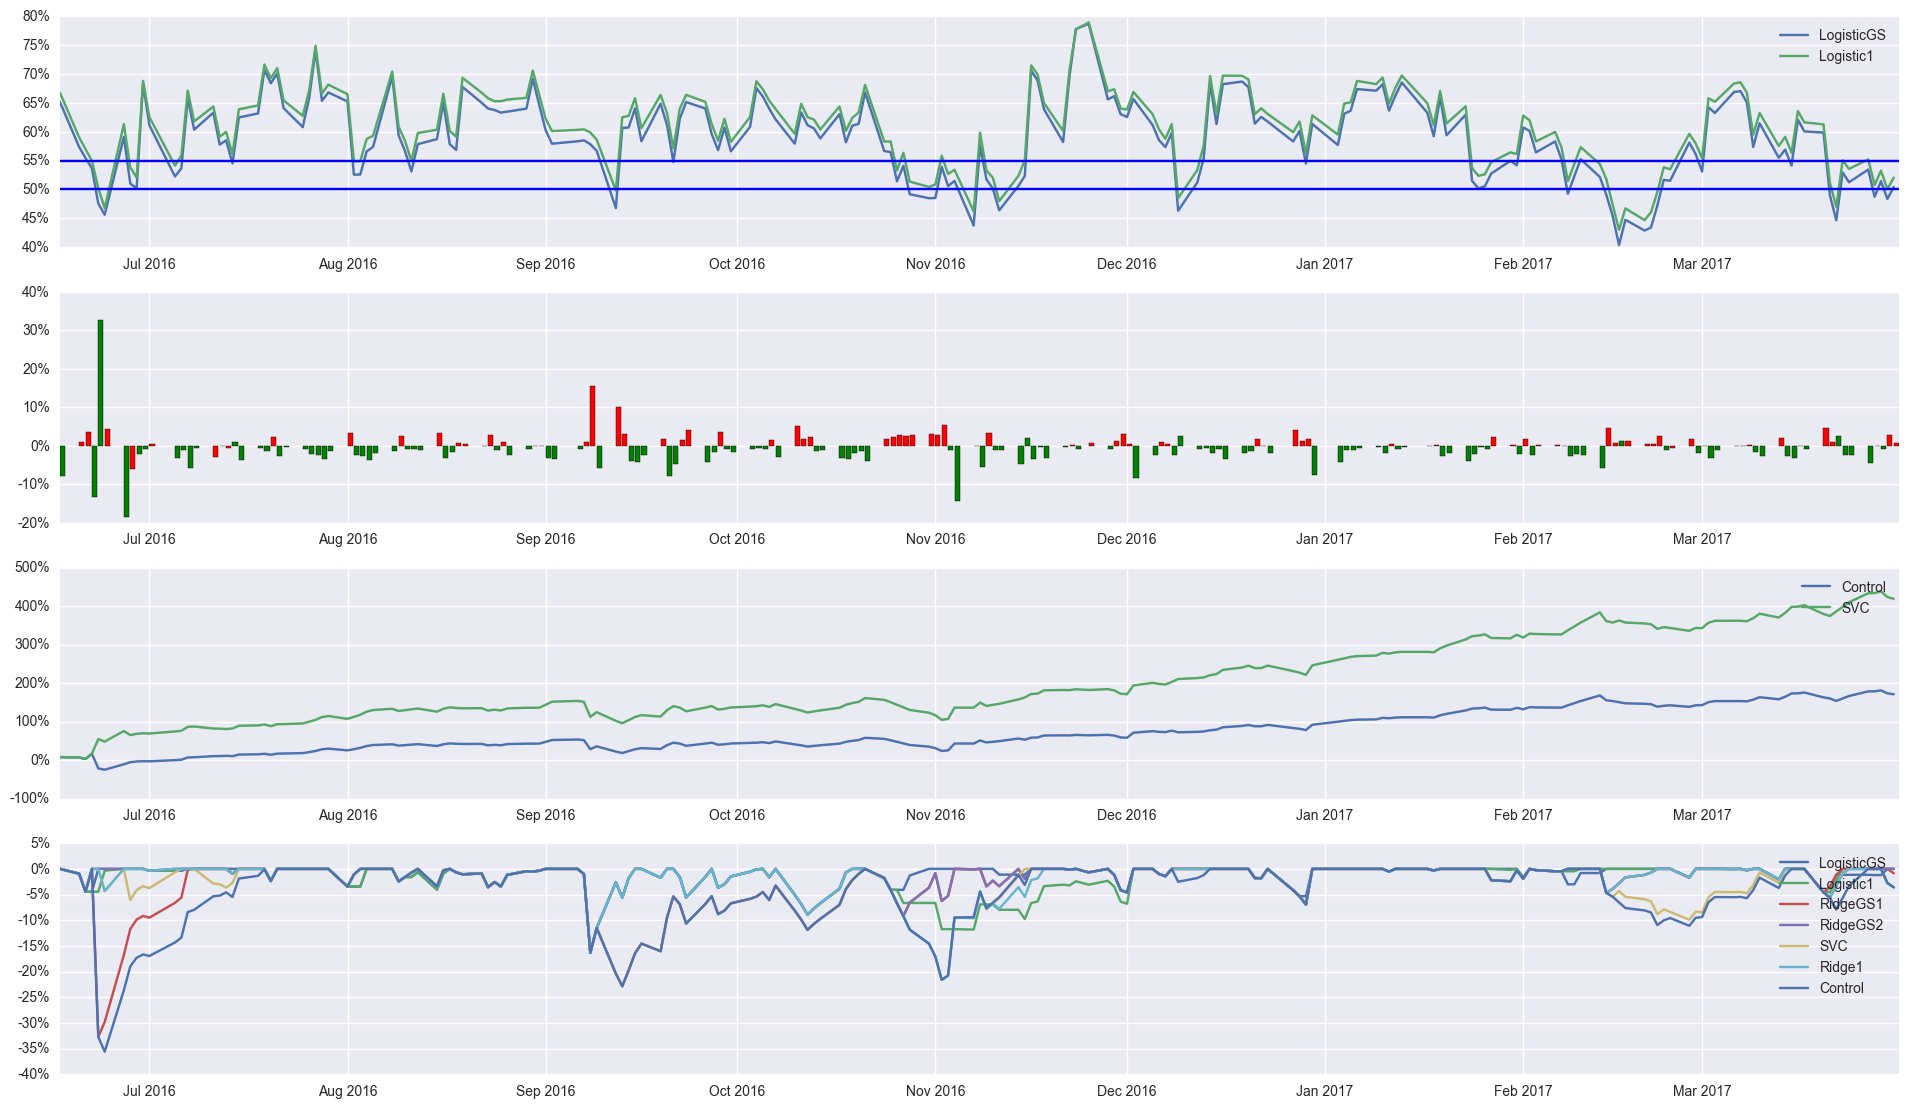

In [15]:
## plot results using custom function defined in helper_functions.py
plot_results(clf_results_dict, thresholds=(log_prob_short_threshold, log_prob_long_threshold), days_history=200, plot_regression='SVC')

In [16]:
## generate summary results using custom function defined in helper_functions.py
summary_periods = [{'from':'2015', 'to':'2017'}, {'from':'2012', 'to':'2017'}, {'from':'2010', 'to':'2017'}]
summary_clf = backtest_summary(df_returns_clf, sample_periods=summary_periods)
try: summary_list_clf
except: summary_list_clf = []
summary_list_clf.append(summary_clf)
summary_list_clf[-1]

,Control,Logistic1,LogisticGS,Ridge1,RidgeGS1,RidgeGS2,SVC
Annual Returns,,,,,,,
2009,107.9%,71.2%,142.8%,181.3%,134.5%,110.2%,-25.5%
2010,139.4%,21.2%,14.1%,14.7%,32.3%,60.4%,50.6%
2011,-43.1%,399.0%,512.0%,333.9%,231.8%,354.3%,170.1%
2012,173.3%,222.0%,199.9%,189.3%,273.7%,244.6%,211.0%
2013,84.1%,57.3%,85.4%,59.4%,125.4%,147.6%,68.5%
2014,-5.6%,-35.6%,-3.0%,-15.9%,-33.5%,6.6%,-14.5%
2015,-20.7%,0.2%,89.8%,1.7%,-9.0%,17.5%,74.2%
2016,106.8%,290.6%,625.2%,552.4%,211.1%,833.6%,388.8%
2017,41.3%,59.0%,49.1%,69.9%,83.5%,82.5%,49.9%


In [45]:
## view result differences vs prior tests
try: summary_diff_clf = (summary_list_clf[-1].applymap(to_number) - summary_list_clf[-2].applymap(to_number)).applymap(to_percent).applymap(lambda x: '' if x=='0.0%' else x)
except: summary_diff_clf = None
# summary_diff_clf

## Regressor Testing

In [18]:
###########################################################################################################################################################
# test the regressors from the previously defined sk_regressors dictionary using time-series split cross validation, specifiing the number of splits below
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
n_splits = 90
###########################################################################################################################################################

X, y = get_dataset(how='regression', to_date=(datetime.datetime.today()-datetime.timedelta(180)).strftime('%Y%m%d'), prediction_days=1, time_step_adjustment=False)
my_pipeline = pipeline_select_features # my_pipeline_fs3 # pipeline_select_features 

df_predictions_reg = pd.DataFrame(index=y.index)

cv = model_selection.TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tqdm_notebook(list(cv.split(X))):
#     train_index = list(range(0, int(len(X)*0.85)))
#     test_index = list(range(len(train_index), len(X)))
    scaler = preprocessing.StandardScaler()
    X_train, X_test, y_train, y_test, test_dates = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index], X.index[test_index]
    #     X_train = pd.DataFrame(my_pipeline.transform(X_train), index=X_train.index) # use for polynomial feature set with imported pipeline that's already fitted
    X_train = pd.DataFrame(my_pipeline.fit_transform(X_train, y), index=X_train.index) # use for given feature set passed in a list using pipeline_select_features
    X_test  = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index)

    for clf_name in sk_regressors:
        clf = sk_regressors[clf_name]
        clf.fit(X_train, y_train)
        regressions = clf.predict(X_test)
        df_predictions_reg.loc[test_dates, clf_name] = regressions

In [19]:
## positioning dataframe creation based on specified thresholds for going long/short
prediction_long_threshold_reg  =  0.0020
prediction_short_threshold_reg = -0.0020

df_returns_reg     = pd.DataFrame(data={'Control': -y})
df_positioning_reg = pd.DataFrame(index=y.index)
df_positioning_reg = df_predictions_reg.applymap(lambda x: -1 if x < prediction_short_threshold_reg else 1 if x > prediction_long_threshold_reg else 0)
df_returns_reg = df_positioning_reg.multiply(-df_returns_reg['Control'], axis=0).join(df_returns_reg['Control'])
df_returns_reg, df_predictions_reg, df_positioning_reg = df_returns_reg['2009':], df_predictions_reg['2009':], df_positioning_reg['2009':]
reg_results_dict = {'returns':df_returns_reg, 'predictions':df_predictions_reg, 'positioning':df_positioning_reg}

## Regressor Results

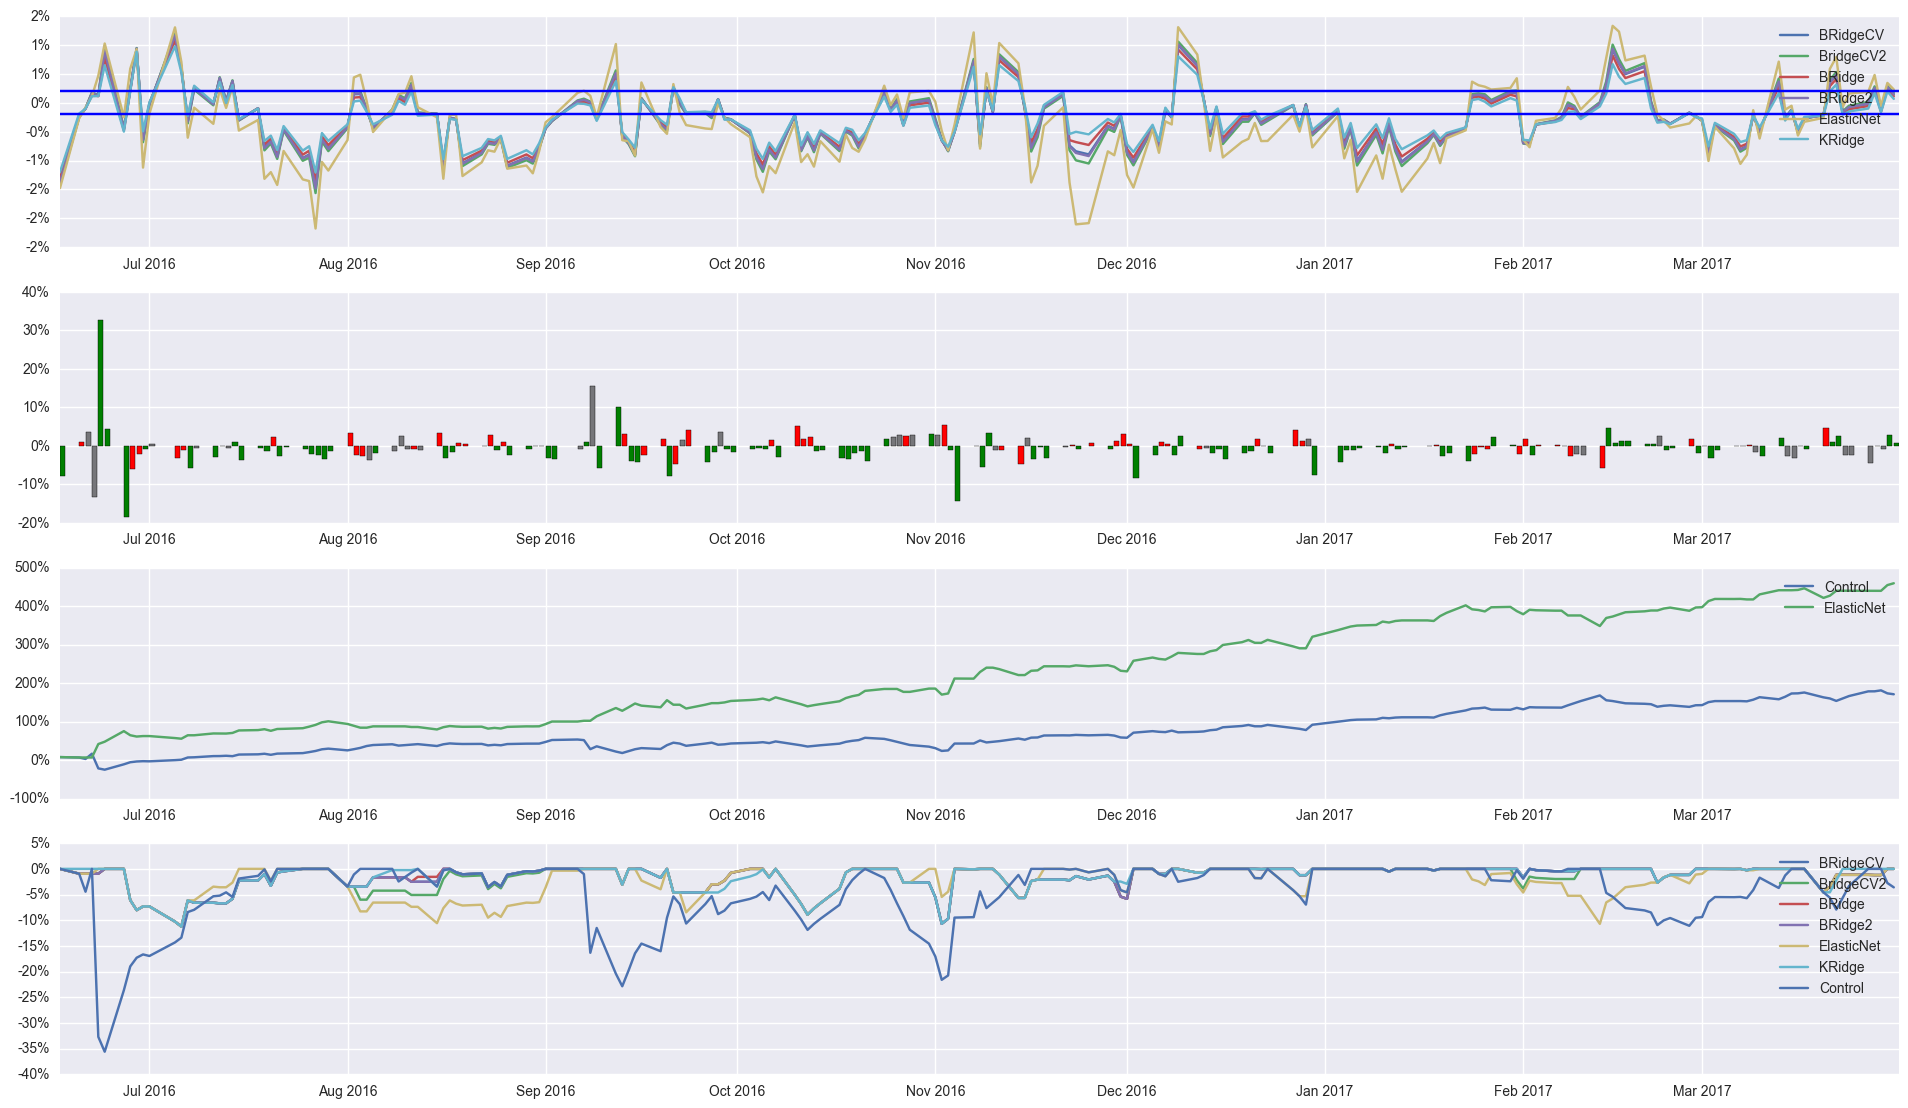

In [21]:
## plot results using custom function defined in helper_functions.py
plot_results(reg_results_dict, thresholds=(prediction_short_threshold_reg, prediction_long_threshold_reg), days_history=200, plot_regression='ElasticNet')

In [22]:
## generate summary results using custom function defined in helper_functions.py
summary_reg = backtest_summary(df_returns_reg, sample_periods=[{'from':'2012', 'to':'2017'}, {'from':'2015', 'to':'2017'}])
try: summary_list_reg
except: summary_list_reg = []
summary_list_reg.append(summary_reg)
summary_list_reg[-1]

,BRidge,BRidge2,BRidgeCV,BridgeCV2,Control,ElasticNet,KRidge
Annual Returns,,,,,,,
2009,-3.4%,34.6%,27.3%,56.2%,107.9%,22.7%,-10.0%
2010,33.0%,53.6%,59.3%,27.3%,139.4%,21.4%,58.5%
2011,319.0%,503.6%,481.0%,484.5%,-43.1%,444.0%,435.6%
2012,262.5%,229.2%,229.2%,228.8%,173.3%,324.8%,239.6%
2013,68.0%,30.5%,27.6%,27.7%,84.1%,2.2%,99.7%
2014,8.1%,11.8%,11.8%,14.7%,-5.6%,-15.9%,-2.2%
2015,204.6%,172.7%,172.7%,208.1%,-20.7%,302.2%,185.5%
2016,354.7%,337.0%,361.7%,340.1%,106.8%,560.3%,342.6%
2017,49.5%,49.5%,49.5%,46.5%,41.3%,33.1%,38.1%


In [23]:
## view result differences vs prior tests
try: summary_diff_reg = (summary_list_reg[-1].applymap(to_number) - summary_list_reg[-2].applymap(to_number)).applymap(to_percent).applymap(lambda x: '' if x=='0.0%' else x)
except: summary_diff_reg = None
summary_diff_reg

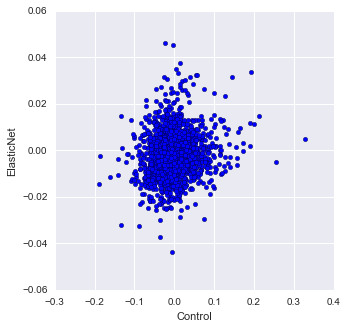

In [25]:
reg_choose = 'ElasticNet'
plt.figure(figsize=(5,5))
plt.scatter(-df_returns_reg['Control'], df_predictions_reg[reg_choose])
plt.xlabel('Control')
plt.ylabel(reg_choose)

In [26]:
metrics.r2_score(-df_returns_reg['Control'].iloc[1000:-1], df_predictions_reg['ElasticNet'].iloc[1000:-1])

0.012893057802478403

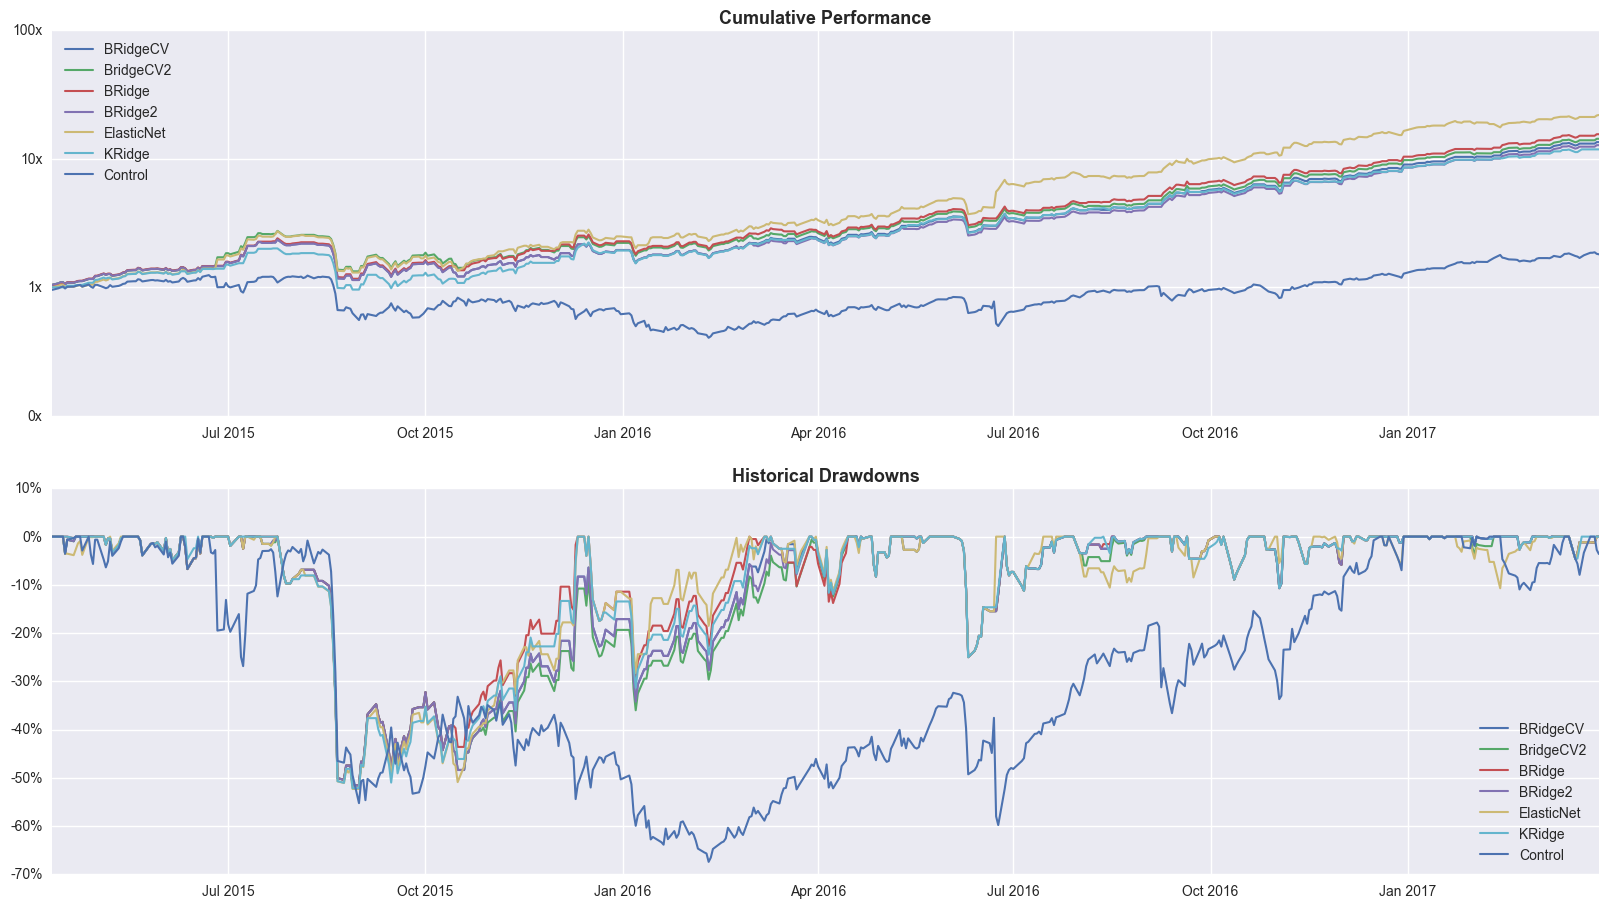

In [27]:
plot_returns(df_returns_reg, days_history=500, log_scale=True)

## PREDICT

In [31]:
##################################################################################################################################################
## train the ML classifiers and regressors - specify the training set timeframe below
from_date = '2006-12-15'
to_date = '2017-09-15'
# select features
my_pipeline = pipeline_select_features #pipeline_select_features # my_pipeline_fs3
##################################################################################################################################################

# refresh the dataset from bloomberg
try: refresh_pickle()
except:
    print("Error: could't refresh data...")
X, y_clf, y_reg = get_dataset(how='classification', from_date=from_date, to_date=to_date)
X_now = get_dataset(how='prediction')
X = my_pipeline.fit_transform(X, y_reg)
X_now = my_pipeline.transform(X_now)
train_params = {'days': 1, 'from_date':from_date, 'to_date':to_date, 'test_size':0.0, 'rand_seed':None, 'threshold':0}
params_filter = {'days': 1, 'threshold':0}

# train the regressors and classifiers using the 'iter_fit' helper function in 'clf_fitter.py'
# iter_fit(sk_regressors, X, y_reg, save_folder='model_results_feat', multithread=False, train_params=train_params)
# iter_fit(sk_classifiers, X, y_clf, save_folder='model_results_feat', multithread=False, train_params=train_params)

# get prediction from specified folder using the 'iter_predict' helper function in 'clf_fitter.py'
iter_predict(X_now, folder='model_results_feat', params_filter=params_filter, pred_hist=10)

,BRidge,BRidge2,BRidgeCV,BridgeCV2,ElasticNet,KRidge,Logistic1,LogisticGS,Ridge1,RidgeGS1,RidgeGS2,SVC
Prediction,0.55%,0.64%,0.63%,0.70%,0.88%,0.45%,41.14%,39.42%,1,1,1,1
,,,,,,,,,,,,
Pred at 15:52:07,0.56%,0.65%,0.63%,0.71%,0.89%,0.45%,41.04%,39.32%,1,1,1,1
Pred at 15:51:54,0.55%,0.64%,0.62%,0.70%,0.83%,0.45%,41.53%,39.93%,1,1,1,1


In [32]:
##################################################################################################################################################
## show selected key fundamental features
##################################################################################################################################################

data = pd.read_pickle('historical_data1.pickle')
my_dataset = pipeline_feature_build.fit_transform(data).join(data, rsuffix='r_')['2006':]
my_features = ['spvixstr index_pct','spy equity_pct', 'vix index', 'weight', 'ux_weighted', 'ux_wgt_prem', 'ctg_weighted', 'ctg_0v1', 'ctg_1v2', 'ctg_momentum', 'spvixstr_5d_perf', 'spy_5d_ema',
               'spy_MACD', 'spy_5d_rv', 'spy_30d_rv', 'spy_rv_momentum', 'ux1', 'ux2']
feature_formats = ['spvixstr index_pct', 'spy equity_pct', 'ctg_weighted', 'ctg_0v1', 'ctg_1v2', 'ctg_momentum', 'spvixstr_5d_perf', 'spy_5d_ema']
select_features = my_dataset[my_features].tail(10)
select_features[feature_formats] = select_features[feature_formats].applymap(lambda x: '{:.1f}%'.format(x*100))
select_features.loc['Percentiles'] = ' '
percentile = my_dataset[my_features].rank(pct=True).tail(5).applymap(to_percent) #apply(lambda x: scipy.stats.percentileofscore(x.dropna(), x[-1]))
select_features = select_features.append(percentile)
select_features.loc['Quantiles'] = ' '
quantile = my_dataset[my_features].quantile(q=[0.10, 0.25, 0.5, 0.75, 0.90]).applymap(to_decimal)
select_features.append(quantile)

,spvixstr index_pct,spy equity_pct,vix index,weight,ux_weighted,ux_wgt_prem,ctg_weighted,ctg_0v1,ctg_1v2,ctg_momentum,spvixstr_5d_perf,spy_5d_ema,spy_MACD,spy_5d_rv,spy_30d_rv,spy_rv_momentum,ux1,ux2
2017-09-14 00:00:00,0.6%,-0.0%,10.44,0.125,12.8312,2.39125,22.9%,9.9%,13.5%,3.3%,-10.0%,0.1%,0.501524,9.86212,9.38158,0.859439,11.475,13.025
2017-09-15 00:00:00,-1.0%,0.1%,10.17,0.0833333,12.775,2.605,25.6%,9.4%,16.2%,4.1%,-8.1%,0.1%,0.580351,7.1639,9.37576,0.85979,11.125,12.925
2017-09-18 00:00:00,-3.9%,0.2%,10.15,0.0416667,12.3521,2.20208,21.7%,5.2%,16.4%,3.5%,-11.1%,0.2%,0.662859,2.31125,9.38008,0.862219,10.675,12.425
2017-09-19 00:00:00,0.0%,0.1%,10.18,1,12.425,2.245,22.1%,22.1%,6.8%,2.9%,-9.3%,0.1%,0.745827,1.48089,9.34364,0.719827,12.425,13.275
2017-09-20 00:00:00,-1.2%,0.0%,9.78,0.95,12.32,2.54,26.0%,25.5%,7.3%,3.5%,-7.4%,0.1%,0.824471,1.50668,9.34259,0.713505,12.275,13.175
2017-09-21 00:00:00,0.4%,-0.3%,9.67,0.9,12.42,2.75,28.4%,27.5%,7.7%,4.6%,-5.4%,-0.0%,0.883713,2.98576,8.29284,0.837253,12.325,13.275
2017-09-22 00:00:00,0.8%,0.0%,9.59,0.85,12.575,2.985,31.1%,29.6%,8.0%,6.0%,-5.5%,-0.0%,0.926472,2.86987,8.29231,0.688236,12.425,13.425
2017-09-25 00:00:00,-0.4%,-0.2%,10.21,0.8,12.575,2.365,23.2%,21.2%,8.1%,4.5%,-3.8%,-0.1%,0.94641,2.61636,7.84661,0.369392,12.375,13.375
2017-09-26 00:00:00,-0.8%,0.1%,10.17,0.75,12.525,2.355,23.2%,20.7%,8.1%,3.1%,-0.3%,-0.0%,0.951236,2.46609,7.84535,0.302093,12.275,13.275
2017-09-27 00:00:00,-0.9%,0.4%,9.81,0.7,12.464,2.654,27.1%,24.1%,8.1%,3.1%,-1.1%,0.1%,0.960999,4.39248,7.91745,0.401262,12.17,13.15


## Scratch code...

In [9]:
my_dataset.tail(10).loc[:,((np.abs(my_dataset.diff().tail(1)) > my_dataset.diff().std()*2).values[0] & (my_dataset.columns.str.contains('ema') == False))]

,tradhigh index_macd,injcjc index_macd
2017-09-01,99.602831,0.416123
2017-09-04,197.840445,0.558222
2017-09-05,229.154216,0.553353
2017-09-06,129.237034,0.492965
2017-09-07,73.973575,20.459817
2017-09-08,143.758548,30.106369
2017-09-11,105.528864,31.314999
2017-09-12,207.375753,28.591204
2017-09-13,207.421075,24.630195
2017-09-14,63.123575,16.121671


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(my_dataset[my_features]['ux_weighted'].tail(6000)) #apply(lambda x: scipy.stats.percentileofscore(x.dropna(), x[-1]))
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.hist(my_dataset['ux_weighted']['2010':'2017'], bins=100)
plt.show()

In [ ]:
dataset = pipeline_feature_build.fit_transform(data)
export_data = pd.DataFrame(dataset[features], columns = dataset[features].columns)
logistic = joblib.load('model_results2/LogisticRegression/LogisticRegression_days-1_threshold-0.0_name-Logistic.pkl')
logistic = logistic.clf
export_data.loc["coef",:] = logistic.coef_
export_data.loc["intercept",0] = logistic.intercept_
export_data.to_excel('aaaaa1.xlsx')

In [ ]:
# In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. 
# A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high 
# recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well
# as returning a majority of all positive results (high recall).

# A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. 
# A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared 
# to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [ ]:
pipeline_scale = Pipeline([
    ('scale', preprocessing.StandardScaler()),
#     ('pca', decomposition.PCA(n_components=60)),
])

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_orig, a.predict(X_test))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['Up','Down'], normalize=True,
                      title='Confusion matrix')
plt.show()

In [ ]:
def create_dataset(X, y, look_back=1):
	dataX, dataY = [], []
	for i in range(len(X)-look_back+1):
		a = X[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(y[i + look_back-1])
	return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train, y_train_reg = get_dataset(how='classification', from_date='2007-01-01', to_date='2015-12-31', classification_categories=[0,1])
X_test, y_test, y_test_reg = get_dataset(how='classification', from_date='2016-01-01', to_date=(datetime.datetime.today()-datetime.timedelta(1)).strftime('%Y%m%d'), classification_categories=[0,1])
my_pipeline = pipeline_scale
X_train = my_pipeline.fit_transform(X_train)
X_test = my_pipeline.fit_transform(X_test)

In [ ]:
step = 1
lookback = 10
batch_size = 64
X_train = my_pipeline.fit_transform(X_train)
X_test = my_pipeline.fit_transform(X_test)

# Vectorization
X_train_rnn, y_train = create_dataset(X_train, y_train, look_back=lookback)
X_test_rnn, y_test = create_dataset(X_test, y_test, look_back=lookback)

y_test_orig = y_test
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# y_train = y_train.reshape(-1,1)

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',#RMSprop(lr=0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train_rnn, y_train,
              batch_size=batch_size,
              epochs=10, verbose=2)

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_orig, model.predict_classes(X_test_rnn))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['Up','Down'], normalize=True,
                      title='Confusion matrix')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.0f}%'.format(cm[i, j]*100) if normalize else '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
con = pdblp.BCon(debug=False)
con.start()
# new_data = con.bdh(new_tks, 'ACTUAL_RELEASE', start_date='20040101', end_date=datetime.datetime.today().strftime('%Y%m%d'), ovrds=[('RELEASE_DATE_OVERRIDE','1')])
new_data = con.bdh(new_tks, 'px_last', start_date='20160101', end_date=datetime.datetime.today().strftime('%Y%m%d'))
con.stop()
# new_data = new_data.xs('spy equity', axis=1, level=0)
# new_data.columns = ['SPY_' + col for col in new_data.columns]# new_data = con.bdh(new_tks, 'PX_LAST', start_date='20040101', end_date=datetime.datetime.today().strftime('%Y%m%d'))
# con.stop()

# con = pdblp.BCon(debug=False)
# con.start()
# aaa = con.ref(mytks, ['name', 'DELAYED_TICK_STREAM_INDICATOR', 'NON_EQY_INDX_STATUS'])
# con.stop()
# data = pd.read_pickle('historical_data1.pickle')
# new_data = new_data.xs('ACTUAL_RELEASE', axis=1, level=1)
# new_data = new_data.xs('PX_LAST', axis=1, level=1)
# data = data.join(new_data)
# data.to_pickle('historical_data1.pickle')

In [62]:
import pybbg_k as pybbg
from pandas import Series, DataFrame, Panel
from datetime import datetime, date, time

ImportError: No module named 'pybbg_k'

In [25]:
def isprime(x, prime_list):
    for prime in prime_list:
        if x % prime == 0:
            return False
    return True

In [26]:
myprimes = []
for i in range(2,100):
    if isprime(i, myprimes):
        myprimes.append(i)

In [27]:
def get_prime(x):
    myprimes = []
    upper_bound = int(x * np.math.log(x) + x * np.math.log(np.math.log(x)) + 10)
    for i in range(2,upper_bound):
        if isprime(i, myprimes):
            myprimes.append(i)
        if len(myprimes) == x:
            return myprimes[x-1]

In [41]:
get_prime(3000)

27449

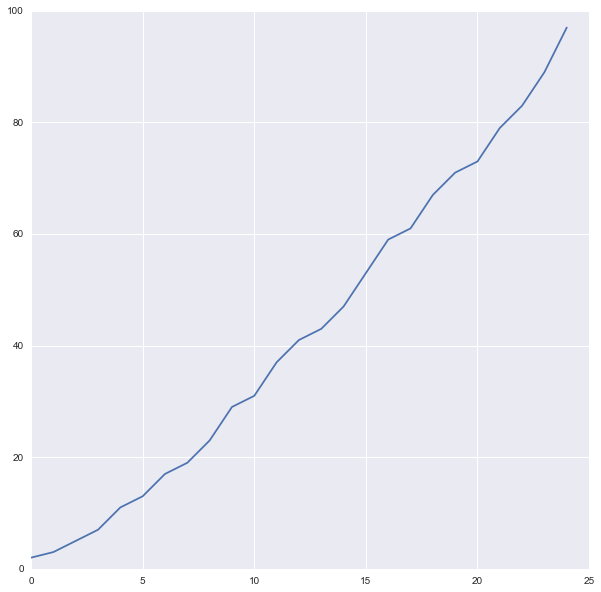

In [42]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(myprimes)
# ax.set_xbound(0,10000)
# ax.set_ybound(0,10000)

In [43]:
primes = [prime for prime in primes.split(' ') if prime.isdigit()]

NameError: name 'primes' is not defined

In [294]:
len(myprimes)

1229